In [1]:
import numpy as np
import pandas as pd
import re
import copy
import gensim

Using TensorFlow backend.


In [232]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Conv1D, Embedding, Dropout, Activation, Flatten
from keras.layers import GlobalMaxPool1D, MaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [87]:
from matplotlib import pyplot as plt
%matplotlib inline

### Read in training data

In [5]:
full_train = pd.read_csv('train.csv')
full_train.shape

(95851, 8)

In [6]:
labels = np.array(full_train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']])

In [75]:
clean_comment = np.zeros(shape=[labels.shape[0]])
clean_comment[np.max(labels,axis=1)==0] = 1

In [8]:
comments=full_train['comment_text'].tolist()

In [10]:
token_dict = {}
token_set = set()
tokenized_comments = copy.copy(comments)
for i in range(len(tokenized_comments)):
    tokenized_comments[i] = re.sub("\n",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("\t",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub(" +",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("'+","'",tokenized_comments[i])    
    tokenized_comments[i] = re.sub("\*+","\*",tokenized_comments[i])   
    tokenized_comments[i] = re.sub("\-+","\-",tokenized_comments[i])
    tokenized_comments[i] = tokenized_comments[i].lower().strip()
    tokenized_comments[i] = tokenized_comments[i].split(' ')
    line_dict = {}
    line_set = set()
    for token in tokenized_comments[i]:        
        if token in token_set:
            token_dict[token] += 1
        else:
            token_set.add(token)
            token_dict[token] = 1

### Read in test data

In [25]:
testdat = pd.read_csv('test.csv')

In [26]:
test_comments0 = testdat['comment_text'].tolist()

In [27]:
test_comments0 = testdat['comment_text'].tolist()
test_comments = copy.copy(test_comments0)
for i in range(len(test_comments)):
    if type(test_comments[i]) is float:
        print(i,test_comments[i])
        test_comments[i]=[]
    else:
        test_comments[i] = re.sub("\n",' ',test_comments[i])
        test_comments[i] = re.sub("\t",' ',test_comments[i])
        test_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',test_comments[i])
        test_comments[i] = re.sub(" +",' ',test_comments[i])
        test_comments[i] = re.sub("'+","'",test_comments[i])    
        test_comments[i] = re.sub("\*+","\*",test_comments[i])   
        test_comments[i] = re.sub("\-+","\-",test_comments[i])
        test_comments[i] = test_comments[i].lower().strip()
        test_comments[i] = test_comments[i].split(' ')
        for token in test_comments[i]:        
            if token in token_set:
                token_dict[token] += 1
            else:
                token_set.add(token)
                token_dict[token] = 1        

52300 nan


In [28]:
token_count = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
token_count.columns = ['token','freq']

In [29]:
token_count = token_count.sort_values('freq',ascending=False)\
    .reset_index(drop=True)
token_count = token_count.reset_index()

In [45]:
reduced_token_count = token_count[token_count['freq']>=15]
reduced_token_count.shape
reduced_token_set = set(reduced_token_count['token'])

In [40]:
reduced_token_count.sample(5)

,index,token,freq
27857,27857,\*ok,17
19764,19764,non\-scientific,30
5459,5459,protestant,227
6613,6613,donating,170
592,592,accept,4440


#### Convert training sequences to index

In [183]:
index_token_dict = pd.Series(reduced_token_count.token.values,index=reduced_token_count.index+1).to_dict()
token_index_dict = pd.Series(reduced_token_count.index.values+1,index=reduced_token_count.token).to_dict()

In [184]:
tokenized_corpus = []
for line in tokenized_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_corpus += [line_token_idx]

In [185]:
print(tokenized_comments[0])
print(tokenized_corpus[0])

['nonsense', 'kiss', 'off', 'geek', 'what', 'i', 'said', 'is', 'true', "i'll", 'have', 'your', 'account', 'terminated']
[853, 2316, 340, 9168, 53, 9, 216, 8, 396, 326, 22, 24, 218, 13547]


In [264]:
comment_length = []
for comment in tokenized_comments:
    comment_length.append(len(comment))
comment_length = np.array(comment_length)
np.percentile(comment_length,80)

90.0

(0, 600)

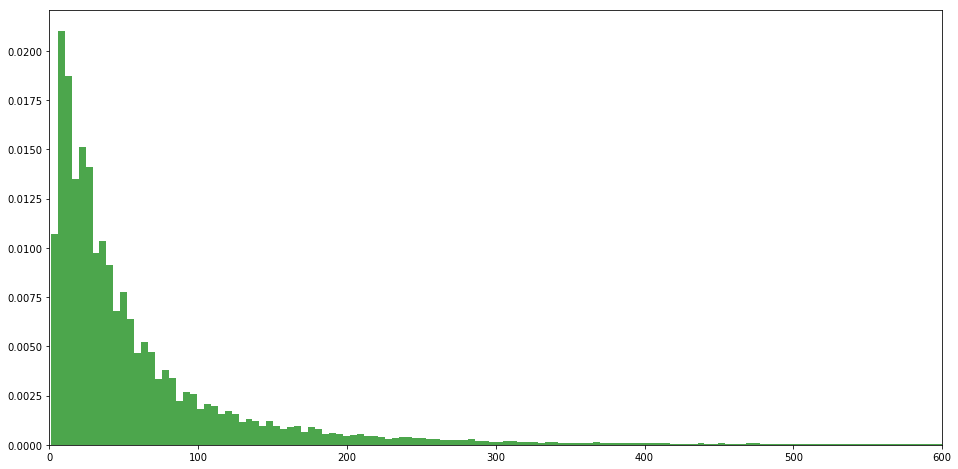

In [98]:
plt.figure(figsize=(16, 8))
n, bins, patches = plt.hist(comment_length, 300, normed=1, facecolor='green', alpha=0.7)
plt.xlim([0,600])

In [263]:
MAX_SEQ_LENGTH=100
tokenized_corpus_padded = pad_sequences(tokenized_corpus,maxlen=MAX_SEQ_LENGTH)

### Load w2v model

In [22]:
w2v_model = gensim.models.Word2Vec.load("wiki_comment_word2vec")

In [23]:
len(w2v_model.wv.vocab)

31293

In [54]:
V = len(reduced_token_set)+1
EMBEDDING_DIM=50
print((V,EMBEDDING_DIM))

(31294, 50)


In [59]:
embed_matrix = np.zeros((V,EMBEDDING_DIM))
for token in token_index_dict.keys():
    embed_matrix[token_index_dict[token]] = w2v_model.wv[token]

In [65]:
embed_matrix.shape

(31294, 50)

### Split training data into train,valid sets

In [265]:
labels0 = shuffle(labels)
tokenized_corpus_padded0 = shuffle(tokenized_corpus_padded)

In [266]:
labels_train,labels_valid, \
seq_train,seq_valid  = \
train_test_split(labels0,tokenized_corpus_padded0,\
                 test_size=0.2,stratify=clean_comment)

In [267]:
print(np.mean(labels_train,axis=0))
print(labels_train.shape)
print(np.mean(labels_valid,axis=0))
print(labels_valid.shape)

[ 0.09660929  0.01011998  0.05339071  0.00301252  0.04949139  0.00869849]
(76680, 6)
[ 0.09540452  0.00985864  0.05294455  0.00386     0.05059726  0.00766783]
(19171, 6)


### Lightweight convolutional model

In [310]:
# Sequence input
sequence_input = Input(shape=(MAX_SEQ_LENGTH,),dtype='int32',name='Input')

# Embedding lookup
embed_seq_unmasked = Embedding(input_dim=V
                              ,output_dim=EMBEDDING_DIM
                              ,weights=[embed_matrix]
                              ,input_length=MAX_SEQ_LENGTH
                              ,trainable=False
                              ,mask_zero=False
                              ,name='Embedding')(sequence_input)

In [311]:
# Convolutional layers: width 1
Conv1_layer = Conv1D(20,1,activation='sigmoid')(embed_seq_unmasked)
#Conv1_layer = MaxPooling1D(1)(Conv1_layer)
Conv1_layer = Conv1D(20,1,activation='sigmoid')(Conv1_layer)
#Conv1_layer = Flatten()(Conv1_layer)
Conv1_layer = GlobalMaxPool1D()(Conv1_layer)

In [284]:
# # Convolutional layers: width 3
# Conv3_layer = Conv1D(50,3,activation='relu')(embed_seq_unmasked)
# Conv3_layer = Conv1D(50,3,activation='relu')(Conv3_layer)
# Conv3_layer = Flatten()(Conv3_layer)
# Conv3_layer = GlobalMaxPool1D()(Conv3_layer)

In [285]:
# Concatenate convolutional outputs
# Conv_cat = concatenate([Conv1_layer,Conv3_layer])

In [312]:
#Conv_dense = Dense(50,activation='relu')(Conv_cat)
Conv_dense = Dense(30,activation='relu'
#                    ,kernel_regularizer=regularizers.l2(0.01)
                  )(Conv1_layer)
Conv_dropout = Dropout(0.5)(Conv_dense)
# Conv_dense2 = Dense(10,activation='relu')(Conv_dropout)
# Conv_dropout2 = Dropout(0.5)(Conv_dense2)
#Conv_output = Dense(6, activation="sigmoid")(Conv_dropout2)
Conv_output = Dense(6, activation="sigmoid"
#                     ,kernel_regularizer=regularizers.l2(0.01)
                   )(Conv_dropout)

In [313]:
cnn_model = Model(inputs=sequence_input, outputs=Conv_output)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 100)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 100, 50)           1564700   
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 100, 20)           1020      
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 100, 20)           420       
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 20)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 30)                630       
_________________________________________________________________
dropout_37 (Dropout)         (None, 30)                0         
__________

In [314]:
history_CNN = cnn_model.fit(seq_train,labels_train
                           ,epochs=5
                           ,batch_size=32
                           ,validation_data=(seq_valid,labels_valid)
                           ,verbose=1)

Train on 76680 samples, validate on 19171 samples
Epoch 1/5
76680/76680 [==============================] - 29s - loss: 0.1880 - acc: 0.9492 - val_loss: 0.1429 - val_acc: 0.9633
Epoch 2/5
76680/76680 [==============================] - 26s - loss: 0.1538 - acc: 0.9631 - val_loss: 0.1418 - val_acc: 0.9633
Epoch 3/5
76680/76680 [==============================] - 28s - loss: 0.1478 - acc: 0.9631 - val_loss: 0.1416 - val_acc: 0.9633
Epoch 4/5
76680/76680 [==============================] - 28s - loss: 0.1457 - acc: 0.9631 - val_loss: 0.1417 - val_acc: 0.9633
Epoch 5/5
76680/76680 [==============================] - 27s - loss: 0.1437 - acc: 0.9631 - val_loss: 0.1417 - val_acc: 0.9633


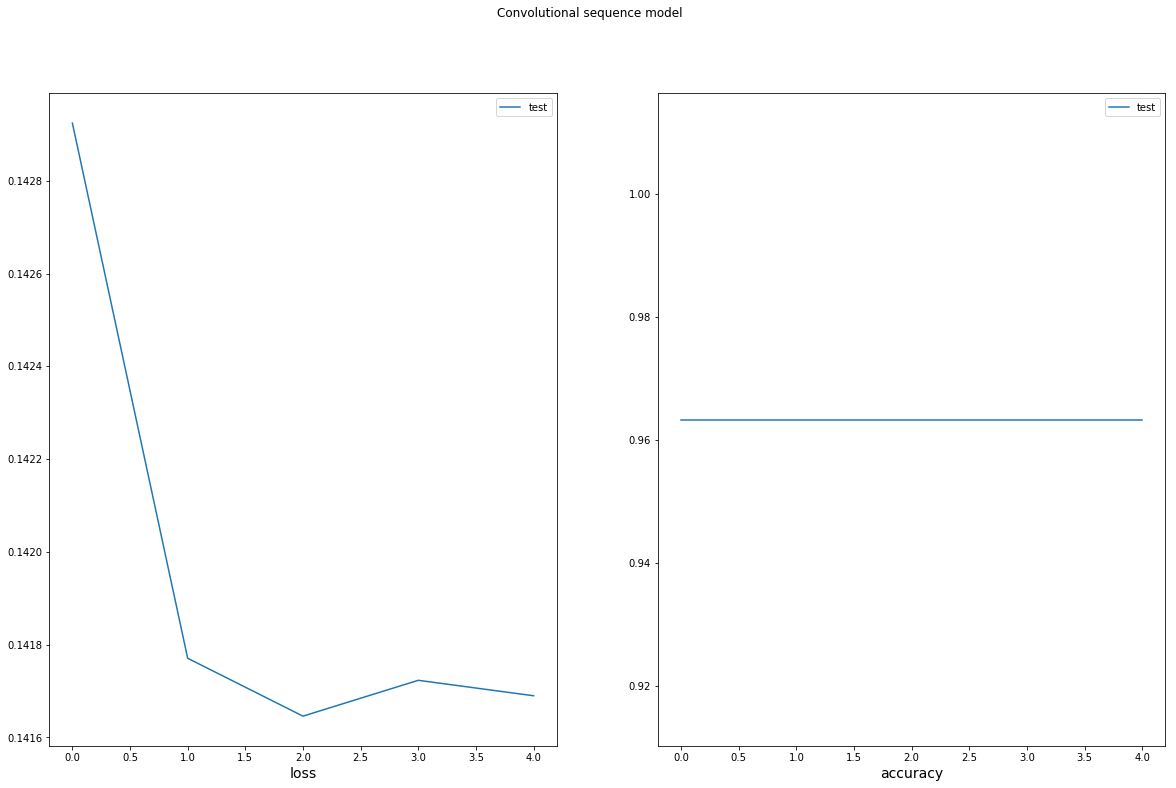

In [315]:
plt.figure(figsize=(20,12))
plt.suptitle("Convolutional sequence model")
plt.subplot(121)
#plt.plot(history_CNN.history['loss'],label='train')
plt.plot(history_CNN.history['val_loss'],label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.xlabel('loss',fontsize=14)
plt.subplot(122)
#plt.plot(history_CNN.history['acc'],label='train')
plt.plot(history_CNN.history['val_acc'],label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.xlabel('accuracy',fontsize=14)

#### Kaggle test set scoring

In [290]:
tokenized_test = []
for line in test_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_test += [line_token_idx]

In [291]:
tokenized_test_padded = pad_sequences(tokenized_test,maxlen=MAX_SEQ_LENGTH)

In [292]:
kaggle_predict = cnn_model.predict(tokenized_test_padded)

In [293]:
kaggle_predict[0:10]

array([[ 0.10039666,  0.00879486,  0.06255528,  0.00303516,  0.058794  ,
         0.00879248],
       [ 0.1000605 ,  0.00918823,  0.06240648,  0.00324678,  0.05884541,
         0.00940535],
       [ 0.10231174,  0.00911551,  0.06350899,  0.00332133,  0.06068011,
         0.00953837],
       [ 0.09988316,  0.01157347,  0.06347191,  0.00439547,  0.06001818,
         0.0116124 ],
       [ 0.10047047,  0.01121789,  0.06360778,  0.00418513,  0.05972213,
         0.01124942],
       [ 0.09035083,  0.00356295,  0.05371544,  0.00094392,  0.04945127,
         0.00381089],
       [ 0.10146926,  0.01036803,  0.06384972,  0.00395578,  0.06134228,
         0.0109328 ],
       [ 0.1011159 ,  0.01138139,  0.06405683,  0.00428042,  0.060682  ,
         0.01143777],
       [ 0.09972531,  0.01025759,  0.06269047,  0.0037267 ,  0.05858477,
         0.01025405],
       [ 0.10397162,  0.01025395,  0.06474994,  0.00386012,  0.06156899,
         0.01045292]], dtype=float32)

In [309]:
print(np.mean(kaggle_predict,axis=0))
print(np.std(kaggle_predict,axis=0))

[ 0.10093965  0.01045526  0.06327797  0.00389634  0.05955742  0.01051272]
[ 0.00200404  0.00264814  0.00192385  0.00141999  0.00219528  0.00249032]


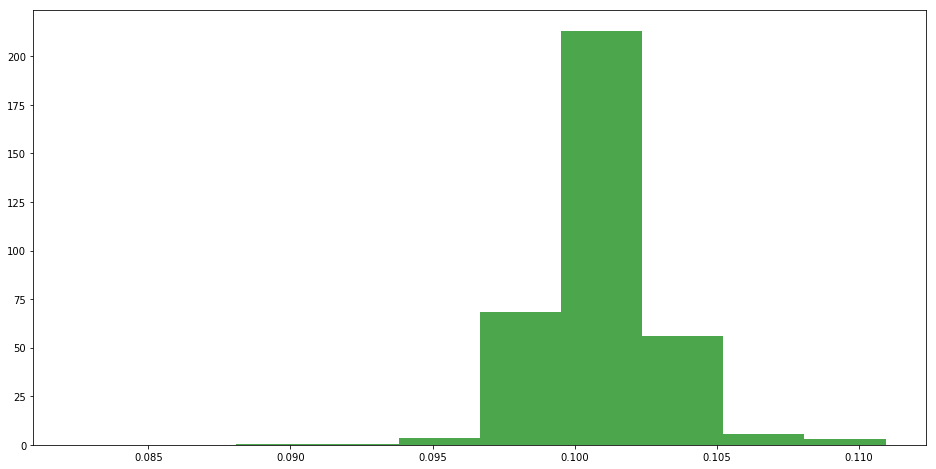

In [295]:
plt.figure(figsize=(16, 8))
n, bins, patches = plt.hist(kaggle_predict[:,0], 10, normed=1, facecolor='green', alpha=0.7)

Well, CNN isn't working very well despite lots of experiments with architecture. I can see that the predictions are basically just the class rates- meaning only the biases 
Next I will have to try out some recurrent approaches.